In [74]:
import pyvo as vo
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
from photutils.aperture import CircularAperture, aperture_photometry
import pandas as pd


In [ ]:
%matplotlib inline


# Extracting a galaxy through the WISE image service

In [ ]:
# using the website that Irsa.ipac relocates you that has a full explanationm of all the code you need
#using NGC 5128: ra= 201.365	dec= -43.019
#define coordinates	
ra = 201.365
dec = -43.019
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')

In [ ]:
# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")


In [ ]:
#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
#im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table

In [ ]:
im_table.to_table().colnames

In [ ]:
im_table.to_table()['sia_url']

In [ ]:
im_table.to_table()['sia_bp_id']
# i believe this gives us the different bandpasses that you can view the image in. 

In [ ]:
for i in range(len(im_table)):
    print(im_table[i])

In [ ]:
#search for the image in the W3 band image
# using a for loop i assume because it may be printed multiple times maybe?
# i printed it above, it could just be because the ID of the one object is printed 4 times due to there being 4 bandpasses but if you define it at W3 not sure why this is all necessary

for i in range(len(im_table)):
    if im_table[i]['sia_bp_id'] == 'W3':
        break
print(im_table[i].getdataurl())
# ahh yes, so the it runs over the "i" in the dataset until it finds W3 and then stops 
# so using "break" makes the for loop stop after it finds the ID of the object inside of W3
# this is prolly very useful if i am looking for multiple objects.

In [ ]:
#Download the image and open it in Astropy
fname = download_file(im_table[i].getdataurl(), cache=True)
image1= fits.open(fname)

In [ ]:
#extract a cutout and plot it
wcs = WCS(image1[0].header)
wcs


In [ ]:
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image1[0].data, pos, (60, 60), wcs=wcs)
wcs = cutout.wcs

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection = wcs)

#vmax at 4000 gives you the (bulge maybe?) right in the center of it
ax.imshow(cutout.data, origin='lower', vmax = 2300, cmap= 'gray_r')

ax.scatter(ra, dec, transform= ax.get_transform('fk5'), facecolor= 'None', s=3000, edgecolor = 'red', alpha = 1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#Axis. get_transform() function in axis module of matplotlib library is used to get the "Transform instance used by this artist"

In [ ]:
#with fits.open('../Data/image_2MASS-K_s.fits') as image:
 #   image[0].data      # if you dont want to have to close the image again
    

hdul= fits.open('../Data/image_2MASS-K_s.fits')
hdul.info()

In [ ]:
fits1 = fits.getheader('../Data/image_2MASS-K_s.fits')


In [ ]:
data = hdul[1]

In [ ]:
#converting image data from counts to flux 
# encountered problem because this fits file does not have any other hdu's besides primaryHDU
photflam = hdul[1].header['photflam']
exptime = hdr['exptime']
data = data * photflam / exptime
hdul.close()

In [ ]:
#make sure to run this cell whenever done
hdul.close()

# Exploring the downloadable FITS provided by the website 
to understand the properties of the image

In [ ]:
# looking at the WISE specific fits
hdul = fits.open('../Data/image_WISE-Band-1.fits')
hdul.info()

In [ ]:
hdr = fits.getheader('../Data/image_WISE-Band-1.fits')
hdr
#the units are in units of intensity "DN"

In [ ]:
#opening the image in a way similar to astroimagej
# for single aperture
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(230,230,50)] #and , (180,340,50)

#create aperture objects
aperture = [CircularAperture((x,y),r) for (x,y,r) in ROI]


#perform aperture photometry
photo_table = aperture_photometry(phdul, aperture)
print(photo_table)
#results
for i, aperture in  enumerate(aperture):
    flux = photo_table['aperture_sum_0'][i]
print(flux)
hdul.close()

In [ ]:
# for multiple apertures
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220,220,100), (186,341,11)] #and , (180,340,50)

#results
for i, (x,y,r) in  enumerate(ROI):
   #create aperture objects 
    aperture = CircularAperture((x,y),r)
   #perform aperture photometry
    photo_table = aperture_photometry(phdul, aperture)
    #print(photo_table)
    flux = photo_table['aperture_sum'][0]
    print(f"Region {i+1}: Center=({x}, {y}), Radius={r}")
    print(f"Flux: {flux}")

#visualizing the apertures
for x,y,r in ROI:
    aperture = CircularAperture((x,y),r)
    aperture.plot(color='red', lw = 1.5)


hdul.close()
    

In [ ]:
#code for creating a background ring. also need to retrieve the source-sky uncertainty? leave that for later for now

In [ ]:
#converting vega magnitudesto source flux density for sources with constant power-law spectra: Fv proportional to V^not
#apparent magnitude of vega is .03  and absolute mag is .6
#mvega = .03
#flx_dens_jy = 309.54*(10**(mvega/2.5)


# Flux conversion

In [69]:
#Converting counts in DN to flux density units
#Instrumental Zero Point Magnitude for WISE Source Photometry in the W1 Band is 20.73
#print(phdul)

#Confused cuz I am not sure what the variable is to convert all of the counts to flux


#Calibrated Magnitude
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
counts = flux # or phdul['MEDINT']? which is the median intensity
Mcal = M0instr - 2.5*(np.log10(counts))
#print(Mcal)

#convert Magnitude to Flux
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor
flx_jy = flx_conv_fact * 10**(Mcal/-2.5)
print(flx_jy)



#mvega = .03
#flx_dens_jy = 309.54*(10**(mvega/2.5)


0.014568425603228293


# Multi-aperture photometry code

   Region    X    Y  Radius  Flux (Jy)
0       1  220  220     100   0.727652
1       2  186  341      11   0.014568


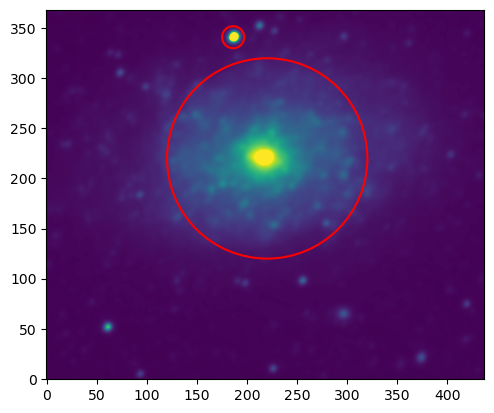

In [97]:
# for multiple apertures while putting in the flux conversion
hdul = fits.open('../Data/image_WISE-Band-1.fits')
phdul = hdul[0].data
plt.imshow(phdul, vmax = 40, origin='lower')

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [(220, 220, 100, 15, 20), (186, 341, 11, 4, 6)] # (x, y, r, inner r, outer r)
#empty data frame to append values of flux to
#display_data = pd.DataFrame(columns= ['Region', 'X', 'Y', 'Radius', 'Flux (Jy)'])
rows=[]
M0instr = 20.5 # find the relative instrumental zero point magnitude in this specific band (W1) in this case it is 20.5 but the general one is also 20.73
flx_conv_fact =  309.54 # the  Zero Magnitude Flux Density conversion factor 

#results
for i, (x, y, r, annulus_inner, annulus_outer) in  enumerate(ROI):
# For the Target
   #define the target aperture objects 
    target_aperture = CircularAperture((x,y),r,)
    
    #perform aperture photometry on target
    target_photo_table = aperture_photometry(phdul, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
    #calculate area of annulus
    target_area = target_aperture.area



# For the Background Annuli of the Target
    #define the background annulus for the taget (i think i need to do CircularAperture here too tbh)
    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

    #perform aperture photometry on annuli
    annulus_photo_table = aperture_photometry(phdul, annulus_aperture)
    annulus_counts = annulus_photo_table['aperture_sum'][0]
    
    #counts to flux
    Mcal_annul = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

    #calculate area of annulus
    annulus_area = annulus_aperture.area

#calculate the mean background per pixel

    
    
    # Append the result as a dictionary to the list named 'rows'
    rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Flux (Jy)': flx_jy})  #will prolly have to change the name of the Flux here!!!
    
display_data = pd.DataFrame(rows)
print(display_data)

#visualizing the apertures
for x,y,r in ROI:
    aperture = CircularAperture((x,y),r)
    aperture.plot(color='red', lw = 1.5)


hdul.close()

    

# Creating background annuli

In [ ]:
#extract values of DN

#Sum background Annulus and inner aperture

#Convert DN to flux

#subtract background flux to get net flux

#display data in a pandas dataframe

